<a href="https://colab.research.google.com/github/VedantDere0104/GANs/blob/main/Age_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Face Aging With Conditional Generative Adversarial Networks:-https://arxiv.org/abs/1702.01983

In [1]:
####

In [2]:
import torch
from torch import nn
import torchvision
from torchsummary import summary
from tqdm.auto import tqdm

In [3]:
class Encoder(nn.Module):
  def __init__(self , input_channels , z_dim):
    super(Encoder , self).__init__()

    n_filters = 64
    self.conv1 = nn.Conv2d(input_channels , n_filters , kernel_size=2 , stride=2)
    self.conv2 = nn.Conv2d(n_filters , n_filters * 2 , kernel_size=2 , stride=2)
    self.batch_norm1 = nn.BatchNorm2d(n_filters * 2)
    self.conv3 = nn.Conv2d(n_filters * 2 , n_filters * 4 , kernel_size=2 , stride=2)
    self.conv4 = nn.Conv2d(n_filters * 4 , n_filters * 8 , kernel_size=2 , stride=2)
    self.batch_norm2 = nn.BatchNorm2d(n_filters * 8)
    self.conv5 = nn.Conv2d(n_filters * 8 , n_filters * 16 , kernel_size=2 , stride=2)
    self.conv6 = nn.Conv2d(n_filters * 16 , n_filters * 32 , kernel_size=2 , stride=2)
    self.batch_norm3 = nn.BatchNorm2d(n_filters * 32)
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.linear1 = nn.Linear(32768 , n_filters * 4)
    self.linear2 = nn.Linear(n_filters * 4 , n_filters * 2)
    self.linear3 = nn.Linear(n_filters * 2 , n_filters)
    self.linear4 = nn.Linear(n_filters , z_dim)

  def forward(self , x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.batch_norm1(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.batch_norm2(x)
    x = self.conv5(x)
    x = self.relu(x)
    x = self.conv6(x)
    x = self.relu(x)
    x = self.batch_norm3(x)
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [4]:
encoder = Encoder(3 , 64)

In [5]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

--2021-02-03 06:16:59--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M   202MB/s    in 4.0s    

2021-02-03 06:17:03 (192 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [6]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [7]:
def calc_age(taken, dob):

    birth = datetime.fromordinal(max(int(dob) - 366, 1))

  
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [8]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):

    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]


    dob = meta_data['dob'][0]


    photo_taken = meta_data['photo_taken'][0]

    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
    

    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [9]:
# helper scale function
def scale(x, feature_range=(-1, 1)):

    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
# helper one-hot function
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):

    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

In [11]:
class ImageAgeDataset(Dataset):

    def __init__(self, dataset, data_dir, transform=None):

        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [12]:
class Resize(object):
    
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):


    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        # expand dept from 1 to 3 channels for gray images
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [13]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 128
#num_workers = 0

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

# build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [14]:
iter(train_loader).next()

{'age': tensor([ 28,  39,  59,  31,  41,  51,  33,  77,  60,  29,  41,  36,  23,  28,
          38,  25,  32,  36,  19,  77,  51,  42,  30,  33,  28,  33,  29,  59,
          13,  27,  60,  41,  30,  68,  24,  24,  49,  45,  24,  33,  72,  31,
          52,  51,  47,  56,  34,  55,  22,  30,  47,  32,  57,  53,  53,  54,
          46,  33,  46,  28,  42,  67,  78,  49,  22,  32,  26,  31,  48,  43,
          46,  25,  62,  30, 101,  28,  31,  24,  45,  61,  27,  32,  37,  52,
          26,  35,  30,  29,  26,  29,  23,  66,  63,  57,  72,  49,  53,  27,
          26,  70,  17,  25,  39,  26,  21,  39,  31,  40,  28,  26,  58,  23,
          24,  27,  58,  29,  65,  45,  38,  21,  28,  70,  49,  63,  36,  42,
          30,  37]),
 'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2941, 0.3373],
           [1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2980, 0.3412],
           [1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2980, 0.3451],
           ...,
           [0.0902, 0.0784, 0.0941,

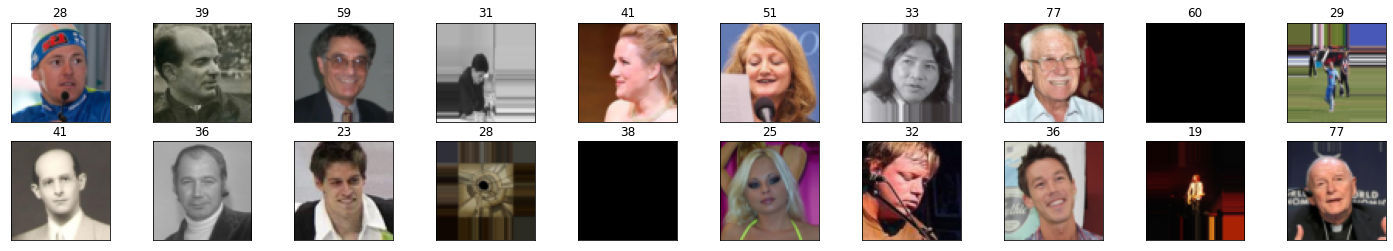

In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
data = dataiter.next()
images, labels = data['image'], data['age']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class conv(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size = 4 , strides = 2 , padding = 1 , batch_norm = True):
    super(conv , self).__init__()

    self.conv_layer = nn.Conv2d(in_channels , out_channels , kernel_size , strides , padding)
    self.batch_norm = batch_norm

    if self.batch_norm:
      self.batchnorm = nn.BatchNorm2d(out_channels)
    
  def forward(self , x):
    x = self.conv_layer(x)
    if self.batch_norm:
      x = self.batchnorm(x)
    
    return x

In [18]:
class Discriminator(nn.Module):
  def __init__(self , y_size , conv_dim = 64):
    super(Discriminator , self).__init__()

    self.y_size = y_size
    self.conv_dim = conv_dim

    self.conv1 = conv(3 , conv_dim , batch_norm=False)
    self.conv2 = conv(conv_dim + y_size , conv_dim * 2)
    self.conv3 = conv(conv_dim * 2 , conv_dim * 4)
    self.conv4 = conv(conv_dim * 4 , conv_dim * 8)
    self.conv5 = conv(conv_dim * 8 , 1 , 4 , 1 , 0 , batch_norm=False)
    self.relu = nn.ReLU(inplace=True)

  def forward(self , x , y):
    x = self.relu(self.conv1(x))
    y = y.view(-1,y.size()[-1],1,1)
    y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
    x = torch.cat([x, y], 1)
    x = self.relu(self.conv2(x))
    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))
    x = self.conv5(x)

    return x


In [19]:
class deconv(nn.Module):
  def __init__(self , in_channels , out_channels , kernel_size = 4 , stride = 2 , padding = 1 , batch_norm = True):
    super(deconv , self).__init__()

    self.convT = nn.ConvTranspose2d(in_channels , out_channels , kernel_size , stride , padding)
    self.batch_norm = batch_norm

    if self.batch_norm:
      self.batchnorm = nn.BatchNorm2d(out_channels)
    
  def forward(self , x):
    x = self.convT(x)
    if self.batch_norm:
      x = self.batchnorm(x)
    return x

In [20]:
class Generator(nn.Module):
  def __init__(self , z_dim , y_dim , conv_dim = 64):
    super(Generator , self).__init__()

    self.deconv1 = deconv(z_dim + y_dim , conv_dim * 8 , kernel_size = 4 , stride=2 , padding = 0)
    self.deconv2 = deconv(conv_dim * 8 , conv_dim * 4 , 4)
    self.deconv3 = deconv(conv_dim * 4 , conv_dim * 2)
    self.deconv4 = deconv(conv_dim * 2 , conv_dim)
    self.deconv5 = deconv(conv_dim , 3 , 4 , batch_norm=False)
    self.relu = nn.ReLU(inplace=True)

  def forward(self , z , y):
    x = torch.cat([z , y] , dim = 1)
    x = x.view(-1, x.size()[-1], 1, 1)
    x = self.relu(self.deconv1(x))
    x = self.relu(self.deconv2(x))
    x = self.relu(self.deconv3(x))
    x = self.relu(self.deconv4(x))
    x = self.deconv5(x)
    x = torch.tanh(x)

    return x
  

In [21]:
conv_dim = 64
z_size = 100
y_size = 6

discriminator = Discriminator(y_size , conv_dim=conv_dim)
generator = Generator(z_size , y_size , conv_dim)

In [22]:
print(discriminator)

Discriminator(
  (conv1): conv(
    (conv_layer): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): conv(
    (conv_layer): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): conv(
    (conv_layer): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): conv(
    (conv_layer): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): conv(
    (conv_layer): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
  (relu): ReLU(inplace=True)
)


In [23]:
print(generator)

Generator(
  (deconv1): deconv(
    (convT): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(2, 2))
    (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): deconv(
    (convT): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): deconv(
    (convT): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv4): deconv(
    (convT): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv5): deconv(
    (convT): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (relu): ReLU(inplace=True)
)


In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
def real_loss(d_out , smooth = False):
  batch_size = d_out.size(0)
  if smooth:
    labels = torch.ones(batch_size) * 0.9

  else:
    labels = torch.ones(batch_size)

  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(d_out.squeeze() , labels)
  return loss

In [26]:
def fake_loss(d_out):
  batch_size = d_out.size(0)
  labels = torch.zeros(batch_size)
  labels = labels.to(device)

  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(d_out.squeeze() , labels)
  return loss

In [27]:
lr = 0.0002
beta1=0.5
beta2=0.999


num_epochs = 50

d_optimizer = torch.optim.Adam(discriminator.parameters() , lr = lr , betas=(beta1 , beta2))
g_optimizer = torch.optim.Adam(generator.parameters() , lr = lr , betas=(beta1 , beta2))


In [28]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]
    
    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [29]:
%%time

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)


generator.to(device)
discriminator.to(device)

import pickle as pkl




samples = []
losses = []

print_every = 300


sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

CPU times: user 2.4 s, sys: 997 ms, total: 3.4 s
Wall time: 9.86 s


In [35]:
for epoch in range(num_epochs):
  
  for batch_i, batch in enumerate(tqdm(train_loader)):

    batch_size = batch['image'].size(0)

    real_images = scale(batch['image'])

    ages = one_hot(batch['age'], bins)

    d_optimizer.zero_grad()

    real_images = real_images.to(device)
    ages = ages.to(device)

    D_real = discriminator(real_images , ages)
    d_real_loss = real_loss(D_real)

    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()

    z = z.to(device)

    fake_images = generator(z, ages)

    D_fake = discriminator(fake_images , ages)
    d_fake_loss = fake_loss(D_fake)
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    g_optimizer.zero_grad()


    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = generator(z, ages)

    D_fake = discriminator(fake_images, ages)
    g_loss = real_loss(D_fake)
    

    g_loss.backward()
    g_optimizer.step()


    if batch_i % print_every == 0:

        losses.append((d_loss.item(), g_loss.item()))
  
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                epoch+1, num_epochs, d_loss.item(), g_loss.item()))
        

  generator.eval() 
  fixed_z = fixed_z.to(device)
  fixed_y = fixed_y.to(device)
  samples_z = generator(fixed_z, fixed_y)
  samples.append(samples_z)
  generator.train() 
  

  checkpoint(generator, discriminator , epoch, model, root_dir)


save_samples_ages(samples, fixed_y, model, root_dir)




Epoch [    1/   50] | d_loss: 0.3449 | g_loss: 4.0547
Epoch [    1/   50] | d_loss: 0.0569 | g_loss: 3.8805



Epoch [    2/   50] | d_loss: 0.2462 | g_loss: 3.0679
Epoch [    2/   50] | d_loss: 0.2046 | g_loss: 4.8940



Epoch [    3/   50] | d_loss: 0.5400 | g_loss: 4.8339
Epoch [    3/   50] | d_loss: 0.1798 | g_loss: 3.8064



Epoch [    4/   50] | d_loss: 0.1140 | g_loss: 3.7390
Epoch [    4/   50] | d_loss: 0.1051 | g_loss: 5.0447



Epoch [    5/   50] | d_loss: 0.2173 | g_loss: 4.0098
Epoch [    5/   50] | d_loss: 0.0997 | g_loss: 5.4080



Epoch [    6/   50] | d_loss: 0.1461 | g_loss: 4.7809
Epoch [    6/   50] | d_loss: 0.2147 | g_loss: 5.3639



Epoch [    7/   50] | d_loss: 0.1567 | g_loss: 4.4533
Epoch [    7/   50] | d_loss: 0.1471 | g_loss: 5.3893



Epoch [    8/   50] | d_loss: 0.6229 | g_loss: 7.3484
Epoch [    8/   50] | d_loss: 1.0117 | g_loss: 11.9807



Epoch [    9/   50] | d_loss: 0.2147 | g_loss: 5.6405
Epoch [    9/   50] | d_loss: 0.2005 | g_loss: 4.7379



Epoch [   10/   50] | d_loss: 0.1957 | g_loss: 4.7502
Epoch [   10/   50] | d_loss: 0.1032 | g_loss: 5.2048



Epoch [   11/   50] | d_loss: 0.0700 | g_loss: 4.2889
Epoch [   11/   50] | d_loss: 0.1704 | g_loss: 6.6236



Epoch [   12/   50] | d_loss: 0.2974 | g_loss: 8.3259
Epoch [   12/   50] | d_loss: 0.1753 | g_loss: 5.2631



Epoch [   13/   50] | d_loss: 0.1692 | g_loss: 4.0509
Epoch [   13/   50] | d_loss: 0.0800 | g_loss: 5.0414



Epoch [   14/   50] | d_loss: 0.1049 | g_loss: 4.1628
Epoch [   14/   50] | d_loss: 0.0264 | g_loss: 3.5702



Epoch [   15/   50] | d_loss: 0.0264 | g_loss: 6.0566
Epoch [   15/   50] | d_loss: 0.0384 | g_loss: 5.0552



Epoch [   16/   50] | d_loss: 0.1791 | g_loss: 5.7629
Epoch [   16/   50] | d_loss: 0.0232 | g_loss: 5.5833



Epoch [   17/   50] | d_loss: 0.0194 | g_loss: 4.4277
Epoch [   17/   50] | d_loss: 0.1945 | g_loss: 6.5957



Epoch [   18/   50] | d_loss: 0.4400 | g_loss: 7.6936
Epoch [   18/   50] | d_loss: 0.0996 | g_loss: 6.5530



Epoch [   19/   50] | d_loss: 2.2146 | g_loss: 8.7024
Epoch [   19/   50] | d_loss: 0.1063 | g_loss: 5.9201



Epoch [   20/   50] | d_loss: 0.9369 | g_loss: 0.4992
Epoch [   20/   50] | d_loss: 0.0274 | g_loss: 5.9303



Epoch [   21/   50] | d_loss: 0.2075 | g_loss: 8.7163
Epoch [   21/   50] | d_loss: 0.0123 | g_loss: 4.6532



Epoch [   22/   50] | d_loss: 0.1546 | g_loss: 6.1469
Epoch [   22/   50] | d_loss: 0.0690 | g_loss: 6.8425



Epoch [   23/   50] | d_loss: 1.1079 | g_loss: 6.3696
Epoch [   23/   50] | d_loss: 0.0315 | g_loss: 6.1940



Epoch [   24/   50] | d_loss: 0.1906 | g_loss: 4.9353
Epoch [   24/   50] | d_loss: 0.0280 | g_loss: 4.2421



Epoch [   25/   50] | d_loss: 0.0318 | g_loss: 6.6373
Epoch [   25/   50] | d_loss: 0.0443 | g_loss: 5.3653



Epoch [   26/   50] | d_loss: 0.0223 | g_loss: 4.7029


KeyboardInterrupt: ignored

In [36]:
def view_samples(epoch, samples, ages):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img, age in zip(axes.flatten(), samples[epoch], ages):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) 
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(age)
        im = ax.imshow(img.reshape((64,64,3)))

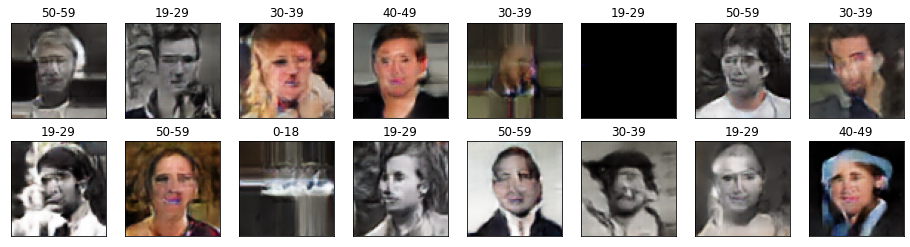

In [37]:
fixed_y_ages = oh_to_class(fixed_y)
_ = view_samples(-1, samples, fixed_y_ages)